In [ ]:
#Import packages
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import scipy
from scipy import stats
from scipy.stats import pearsonr
from collections import Counter
import collections
!pip install FundamentalAnalysis
import FundamentalAnalysis as fa
!pip install empyrical
import empyrical

!pip install quantstats
import quantstats as qs
qs.extend_pandas()

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for empyrical: filename=empyrical-0.5.3-cp36-none-any.whl size=37087 sha256=76936a05135b3a67d30462d46b3af851fbfe5f518cdb7eba8c583d456a399fd9
  Stored in directory: /root/.cache/pip/wheels/10/a4/3b/951bd609878a82fd72b9ea23699daf1eaada4ff6f583152876
Successfully built empyrical


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
from google.colab import files
files = files.upload()

Saving ASCI_Score_1.csv to ASCI_Score_1.csv


In [ ]:
csv_file = open("ASCI_Score_1.csv", "r")
df = pd.read_csv(csv_file)

In [ ]:
#include category filter (Private, Public, Defunct, Subsidiary)
def get_acsi_scores(input_df, industry, years, subsidiaries, plot_data, data_format):

  #Splitting the company Name from the company type
  company_type = []
  company_name = []
  for i in input_df['Company Name']:
    i = i.replace("\xa0", "")
    start_point = i.find('[')
    end_point = i.find(']')
    company_type.append(i[start_point+1:end_point])
    company_name.append(i[0:start_point])


  #Selecting the years to remove from the dataframe
  year_options = ['95', '96', '97', '98', '99', '00', '01', '02', '03','04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15','16', '17', '18', '19', '20']
  years_to_remove = []
  for year in year_options:
    if year in years:
      pass
    else:
      years_to_remove.append(year)


  #removing columns from dataframe
  df3 = pd.DataFrame()
  df3['Company Name'] = company_name
  df3['Company Type'] = company_type
  df2 = df.drop(axis=1, labels=years_to_remove)
  df2 = df2.drop(axis=1, labels=['Company Name', 'Base-\nline', 'Previous\nYear\n%\nChange', 'Notes', 'Type (Public, Subsidiary, Private, Defunct, Government)'])
  #df2 = df2.drop(axis=1, labels=years_to_remove)
  df4 = pd.concat([df3, df2], axis=1)
  df4.dropna(subset=["Ticker Symbol"], inplace=True)

  #Remove all companies without data within these years
  df4.replace("NM", float("NaN"), inplace=True)
  df4.replace("NM***", float("NaN"), inplace=True)
  df4.replace("^", float("NaN"), inplace=True)
  df4.replace("\xa0", float("NaN"), inplace=True)
  df4.replace("#", float("NaN"), inplace=True)
  df4.replace("†", float("NaN"), inplace=True)
  df4.dropna(inplace=True)

  #remove all subsidiaries
  if subsidiaries == False: 
    df4['Division'].replace("Yes", float("NaN"), inplace=True)
    df4.dropna(inplace=True)
    df4.drop(axis = 1, labels = ['Division'], inplace=True)
  
  #df4.reset_index(drop=True)

  count = 0 
  relevant_companies = []
  for i in df4['Company Type']:
    if i == industry:
      relevant_companies.append(count)
    count = count + 1


  #selecting only companies in the selected industry
  if industry == "All":
    df5 = df4
  else:
    df5 = df4.iloc[relevant_companies]



  #convert strings to int
  for k in years:
    df5[str(k)] = df5[str(k)].astype(int)

  #Drop Non-Int Columns for Plotting
  if subsidiaries == False:
    df7 = df5.drop(axis = 1, labels = ['Company Name', 'Company Type', 'Ticker Name', 'Exchange'])
  if subsidiaries == True:
    df7 = df5.drop(axis = 1, labels = ['Company Name', 'Company Type', 'Ticker Name', 'Exchange', 'Division'])
  
  new_index = {}
  count = 0
  for i in df7.columns:
    if count == 0:
      new_index[i] = i
    if count > 0:
      new_index[i] = ("20" + str(i) + "-01-01")
    count = count + 1
  
  df7.rename(new_index, axis='columns', inplace=True)
      
  df7.set_axis(df7['Ticker Symbol'], axis = 0, inplace=True)
  df7.drop(axis = 1, labels = ['Ticker Symbol'], inplace=True)
  df7 = df7.transpose()
  #print(df7)

  if data_format == "Percent":
    df7 = df7.pct_change()

  if plot_data == True:
    df7.plot()
    plt.show()

  return df7

In [ ]:
def get_stock_data(backtest_acsi_test):
  stock_data_test = pd.DataFrame()
  for k in backtest_acsi_test.columns:
    sample1 = fa.stock_data(k, period='10y', interval = "1mo")
    first_cut = backtest_acsi_test.index[0]
    last_cut = backtest_acsi_test.index[len(backtest_acsi_test.index)-1]
    count = 0
    for i in sample1.index:
      if str(i) == first_cut:
        first_cut = count
      if str(i) == last_cut:
        #we want January 1st, not december 1st so we get a full year on the last piece of data
        last_cut = count + 1
      count = count + 1
    sample1.iloc[first_cut:last_cut]
    stock_data_test[k] = sample1.iloc[first_cut:last_cut]['open']
      
  return stock_data_test  

In [ ]:

def run_backtest(sector, initial_capital):
  


  #Designing the trading system
  backtest_range = ['12', '13', '14', '15', '16', '17', '18', '19']
  capital = initial_capital
  backtest_acsi_test = get_acsi_scores(df, sector, backtest_range, False, False, "Raw")
  stocktest = get_stock_data(backtest_acsi_test)

  count = 0
  portfolio_dict = {}
  portfolio_dict['Available Funds'] = capital
  for i in stocktest.columns:
    portfolio_dict[i] = 0

  portfolio_worth = []

  time_count = 0
  for i in stocktest.index:



    #If the year changes, time to rebalance the portfolio.
    if str(i) in backtest_acsi_test.index:
      #sell all current positions:
      for j in stocktest.columns:
        #Add the current worth of the position to the available funds
        portfolio_dict['Available Funds'] = portfolio_dict['Available Funds'] + portfolio_dict[j]*stocktest[j][time_count]

        #set the position to zero
        portfolio_dict[j] = 0



      #pull up ACSI data for that date
      score_max = backtest_acsi_test.loc[str(i)].max()
      score_min = backtest_acsi_test.loc[str(i)].min()

      #if the max and min are the same, do nothing
      if score_max == score_min:
        pass
      
      #else, record the ticker with the highest score and the ticker with the lowest score
      else: 
        ticker_long = []
        #ticker_short = []
        count = 0 
        for k in backtest_acsi_test.loc[str(i)]:
          if backtest_acsi_test.loc[str(i)][count] == score_min:
            ticker_long.append(backtest_acsi_test.loc[str(i)].index[count])
          #if backtest_acsi_test.loc[str(i)][count] == score_min:
            #ticker_short.append(backtest_acsi_test.loc[str(i)].index[count])
          count = count + 1
      
      #calculate the number of positions to take
      position_number = len(ticker_long)
      capital_per_position = portfolio_dict['Available Funds']/position_number


      ###LOGGING CODE
      #print(ticker_long)

      #fetch the price of each position, calculate how many shares you can purchase with the available funds, add to portfolio, subtract funding from available capital
      for j in ticker_long:
        #add position quantity to portfolio dictionary
        portfolio_dict[j] = int(capital_per_position/stocktest[j][time_count])
        #print(j, stocktest[j][time_count])

        #subtract the capital used for the purchase from the available funds
        portfolio_dict['Available Funds'] = portfolio_dict['Available Funds'] - portfolio_dict[j]*stocktest[j][time_count]
        
      #print(ticker_long, position_number, capital_per_position)

    #calculate portfolio worth here,
    #set current_worth equal to the available funds
    current_worth = portfolio_dict['Available Funds']
    for j in ticker_long:
      #then add the worth of each position
      current_worth = current_worth + portfolio_dict[j]*stocktest[j][time_count]
    
    #append the information to the portfolio worth list
    portfolio_worth.append(current_worth)
    #print(portfolio_dict)
    

    ####
    time_count = time_count + 1
  low_strategy = portfolio_worth
  #Designing the trading system
  backtest_range = ['12', '13', '14', '15', '16', '17', '18', '19']
  capital = initial_capital
  backtest_acsi_test = get_acsi_scores(df, sector, backtest_range, False, False, "Raw")
  stocktest = get_stock_data(backtest_acsi_test)

  count = 0
  portfolio_dict = {}
  portfolio_dict['Available Funds'] = capital
  for i in stocktest.columns:
    portfolio_dict[i] = 0

  portfolio_worth = []

  time_count = 0
  for i in stocktest.index:



    #If the year changes, time to rebalance the portfolio.
    if str(i) in backtest_acsi_test.index:
      #sell all current positions:
      for j in stocktest.columns:
        #Add the current worth of the position to the available funds
        portfolio_dict['Available Funds'] = portfolio_dict['Available Funds'] + portfolio_dict[j]*stocktest[j][time_count]

        #set the position to zero
        portfolio_dict[j] = 0



      #pull up ACSI data for that date
      score_max = backtest_acsi_test.loc[str(i)].max()
      score_min = backtest_acsi_test.loc[str(i)].min()

      #if the max and min are the same, do nothing
      if score_max == score_min:
        pass
      
      #else, record the ticker with the highest score and the ticker with the lowest score
      else: 
        ticker_long = []
        #ticker_short = []
        count = 0 
        for k in backtest_acsi_test.loc[str(i)]:
          if backtest_acsi_test.loc[str(i)][count] == score_max:
            ticker_long.append(backtest_acsi_test.loc[str(i)].index[count])
          #if backtest_acsi_test.loc[str(i)][count] == score_min:
            #ticker_short.append(backtest_acsi_test.loc[str(i)].index[count])
          count = count + 1
      
      #calculate the number of positions to take
      position_number = len(ticker_long)
      capital_per_position = portfolio_dict['Available Funds']/position_number


      ###LOGGING CODE
      #print(ticker_long)

      #fetch the price of each position, calculate how many shares you can purchase with the available funds, add to portfolio, subtract funding from available capital
      for j in ticker_long:
        #add position quantity to portfolio dictionary
        portfolio_dict[j] = int(capital_per_position/stocktest[j][time_count])
        #print(j, stocktest[j][time_count])

        #subtract the capital used for the purchase from the available funds
        portfolio_dict['Available Funds'] = portfolio_dict['Available Funds'] - portfolio_dict[j]*stocktest[j][time_count]
        
      #print(ticker_long, position_number, capital_per_position)

    #calculate portfolio worth here,
    #set current_worth equal to the available funds
    current_worth = portfolio_dict['Available Funds']
    for j in ticker_long:
      #then add the worth of each position
      current_worth = current_worth + portfolio_dict[j]*stocktest[j][time_count]
    
    #append the information to the portfolio worth list
    portfolio_worth.append(current_worth)
    #print(portfolio_dict)
    

    ####
    time_count = time_count + 1
  high_strategy = portfolio_worth

  #SPY
  #S&P 500 

  spy_data = fa.stock_data('SPY', period='10y', interval = "1mo")
  first_cut = backtest_acsi_test.index[0]
  last_cut = backtest_acsi_test.index[len(backtest_acsi_test.index)-1]
  count = 0
  for i in spy_data.index:
    if str(i) == first_cut:
      first_cut = count
    if str(i) == last_cut:
      #we want January 1st, not december 1st so we get a full year on the last piece of data
      last_cut = count + 1
    count = count + 1
  spy_data.iloc[first_cut:last_cut]
  #spy_data = spy_data.iloc[first_cut:last_cut]['open']
  spy_data = spy_data.iloc[first_cut:last_cut]
  
  capital = initial_capital
  total_stocks = int(capital/spy_data['open'][0])
  capital = capital - total_stocks*spy_data['open'][0]

  spy_portfolio = []
  count = 0
  for i in spy_data['open']:
    spy_portfolio.append(capital + total_stocks*spy_data['open'][count])
    count = count + 1  

  portfolio_df = pd.DataFrame()
  portfolio_df['Low Satisfaction Strategy'] = low_strategy
  portfolio_df['High Satisfaction Strategy'] = high_strategy
  portfolio_df['S&P 500 (Buy & Hold)'] = spy_portfolio
  matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)

  portfolio_df.plot(linestyle = "--")
  plt.title(('Industry: {industry_title}').format(industry_title = sector))
  plt.xlabel('Months')
  plt.ylabel('Portfolio Value (USD)')
  plt.show()

  #Calculate Metrics
  from empyrical import max_drawdown, alpha_beta
  benchmark_delta = np.array([(100 * a1 / a2 - 100)/100 for a1, a2 in zip(spy_portfolio[1:], spy_portfolio)])
  low_strategy_delta = np.array([(100 * a1 / a2 - 100)/100 for a1, a2 in zip(low_strategy[1:], low_strategy)])
  high_strategy_delta = np.array([(100 * a1 / a2 - 100)/100 for a1, a2 in zip(high_strategy[1:], high_strategy)])


  #Low Strategy Drawdown
  alpha, beta = alpha_beta(low_strategy_delta, benchmark_delta)
  print('Low Satisfaction Strategy')
  print('Maximum Drawdown:', str(round(max_drawdown(low_strategy_delta)*100, 2)))
  print('Alpha', str(alpha))
  print('Beta', str(beta))
  print('Sharpe Ratio:', qs.stats.sharpe(pd.Series(low_strategy_delta), periods=12))


  #High Strategy 
  print("")
  alpha, beta = alpha_beta(high_strategy_delta, benchmark_delta)
  print('High Satisfaction Strategy')
  print('Maximum Drawdown:', str(round(max_drawdown(high_strategy_delta)*100, 2)))
  print('Alpha:', str(alpha))
  print('Beta:', str(beta))
  print('Sharpe Ratio:', qs.stats.sharpe(pd.Series(high_strategy_delta), periods=12))

  




 




  


  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



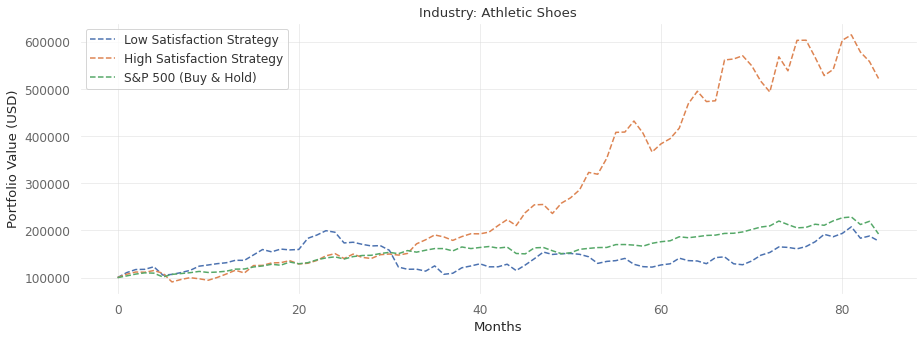

Low Satisfaction Strategy
Maximum Drawdown: -46.38
Alpha 0.3705762670873196
Beta 0.9352925812150763
Sharpe Ratio: 0.4764896128846731

High Satisfaction Strategy
Maximum Drawdown: -21.02
Alpha: 70.49590138070766
Beta: 0.584358223794531
Sharpe Ratio: 1.1531936445134587


In [ ]:
run_backtest('Athletic Shoes', 100000)